# Benign Overfitting in Single-Head Attention

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Parameters
n_samples = 80
d = 6400
rho = 30
eta = 0.05
beta = 0.025

## Preliminaries

### Data generation

In [15]:
def generate_data(n_samples, d, rho, eta=0.0):
    """
    Parameters:
    - n_samples: Number of data points to generate.
    - d: Dimensionality of the feature space.
    - rho: Norm of the signal vectors (mu1 and mu2).
    - eta: Label-flipping probability (default: 0.0).

    Returns:
    - X: Generated data points, shape (n_samples, 2, d).
    - y: Labels, shape (n_samples,).
    - clean_1: Indices of non-flipped samples where u = mu1.
    - clean_2: Indices of non-flipped samples where u = mu2.
    - noisy_1: Indices of flipped samples where u = mu1.
    - noisy_2: Indices of flipped samples where u = mu2.
    """
    print('Generating data...')

    # Generate orthogonal signal vectors mu1 and mu2
    mu1 = np.random.randn(d)
    mu1 = mu1 / np.linalg.norm(mu1) * rho

    mu2 = np.random.randn(d)
    mu2 -= mu2 @ mu1 / (np.linalg.norm(mu1)**2) * mu1  # Orthogonalize mu2 w.r.t mu1
    mu2 = mu2 / np.linalg.norm(mu2) * rho

    # Generate labels
    y = np.random.choice([+1, -1], size=n_samples)

    # Precompute noise covariance matrix
    covariance_matrix = np.eye(d) - (np.outer(mu1, mu1) + np.outer(mu2, mu2)) / (rho**2)

    # Generate noise vectors
    noise = np.random.multivariate_normal(mean=np.zeros(d), cov=covariance_matrix, size=n_samples)

    # Generate signals
    signals = np.where(y[:, None] == 1, mu1, mu2)  # Shape: (n_samples, d)

    # Create the data points
    X = np.zeros((n_samples, 2, d))
    token_choices = np.random.choice([0, 1], size=n_samples)  # Randomly select which token gets the signal
    X[np.arange(n_samples), token_choices, :] = signals
    X[np.arange(n_samples), 1 - token_choices, :] = noise

    # Apply label flipping
    flip_mask = np.random.rand(n_samples) < eta
    y_flipped = np.where(flip_mask, -y, y)

    # Separate indices for clean and noisy data
    clean_indices = np.where(~flip_mask)[0]
    noisy_indices = np.where(flip_mask)[0]

    clean_1 = clean_indices[y[clean_indices] == 1]
    clean_2 = clean_indices[y[clean_indices] == -1]
    noisy_1 = noisy_indices[y[noisy_indices] == 1]
    noisy_2 = noisy_indices[y[noisy_indices] == -1]

    print('Data generated.')
    return X, y_flipped, clean_indices, noisy_indices


In [16]:
np.random.seed(0)
X, y, clean_indices, noisy_indices  = generate_data(n_samples, d, rho, eta)
num_iterations = 2
beta = 0.01

Generating data...
Data generated.


### Single-head Attention Model

In [17]:
# Softmax
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [18]:
def single_head_attention(X, p, v):
    """
    Compute the single-head attention model.

    Parameters:
    - X: numpy array of shape (n_samples, 2, d), input data where each sample has two tokens.
    - p: numpy array of shape (d,), trainable attention vector.
    - v: numpy array of shape (d,), trainable linear head vector.

    Returns:
    - f_values: numpy array of shape (n_samples,), attention model outputs for each sample.
    """

    # Compute attention scores using the softmax function
    Xp = np.dot(X, p)  # (n_samples, 2)
    s = softmax(Xp)  # (n_samples, 2), attention weights

    # Compute attention-weighted sum of tokens
    r = np.einsum('ij,ijk->ik', s, X)  # (n_samples, d)

    # Compute model output
    f_values = np.dot(r, v)  # Shape: (n_samples,)

    return f_values


## Benign Overfitting with Gradient Descent

In [19]:
# Logistic loss
def logistic_loss(z):
    return np.log(1 + np.exp(-z))

In [20]:
def compute_gradients(X, y, v, p, beta):
    """
    Compute gradients for v and p for a single iteration of GD.
    
    Parameters:
    - X: numpy array of shape (n_samples, 2, d), input data.
    - y: numpy array of shape (n_samples,), labels (+1 or -1).
    - v: numpy array of shape (d,), current vector v.
    - p: numpy array of shape (d,), current vector p.
    - beta: step size for gradient descent.
    
    Returns:
    - Updated v and p after one iteration of gradient descent.
    """
    
    # Compute predictions
    predictions = single_head_attention(X, p, v)
    
    # Logistic loss gradient
    sigmoid = 1 / (1 + np.exp(-y * predictions))  # (n_samples,)
    grad_v = -np.dot((1 - sigmoid) * y, np.einsum('ij,ijk->ik', softmax(np.dot(X, p)), X)) / X.shape[0]  # (d,)
    grad_p = np.zeros_like(p)  # Initialize gradient for p
    
    for i in range(X.shape[0]):
        attention_weights = softmax(np.dot(X[i], p))
        grad_softmax = attention_weights[0] * (1 - attention_weights[0]) * X[i, 0] \
                     + attention_weights[1] * (1 - attention_weights[1]) * X[i, 1]
        grad_p += (1 - sigmoid[i]) * y[i] * np.dot(v, grad_softmax)
    
    grad_p /= X.shape[0]
    
    # Update v and p using gradient descent
    v -= beta * grad_v
    p -= beta * grad_p
    
    return v, p

In [33]:
def plot_metrics(train_acc, clean_probs, noisy_probs):
    """
    Plot the metrics during training: train/test accuracies and softmax probabilities.
    
    Parameters:
    - train_acc: List of train accuracies.
    - test_acc: List of test accuracies.
    - clean_probs: List of softmax probabilities for clean samples.
    - noisy_probs: List of softmax probabilities for noisy samples.
    """
    # Plot Train and Test Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_acc)), train_acc, label='Train Accuracy')
    #plt.plot(range(len(test_acc)), test_acc, label='Test Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy during Training')
    plt.legend()

    # Plot Softmax Probabilities for Clean and Noisy Samples
    plt.subplot(1, 2, 2)
    plt.plot(range(len(clean_probs)), clean_probs, label='Clean Sample Probabilities')
    plt.plot(range(len(noisy_probs)), noisy_probs, label='Noisy Sample Probabilities')
    plt.xlabel('Iteration')
    plt.ylabel('Softmax Probability')
    plt.title('Softmax Probability of Signal Token')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [39]:
def train_model(X, y, d, num_iterations, beta, clean_indices, noisy_indices):
    """
    Train the single-head attention model using gradient descent.
    
    Parameters:
    - X: numpy array of shape (n_samples, 2, d), input data.
    - y: numpy array of shape (n_samples,), labels (+1 or -1).
    - d: int, dimensionality of input data.
    - num_iterations: int, number of GD iterations.
    - beta: float, step size for gradient descent.
    
    Returns:
    - v, p: Trained parameters.
    """
    # Initialize parameters
    v = np.zeros(d)
    p = np.zeros(d)

    # Metrics to track
    train_acc = []
    test_acc = []
    clean_probs = []
    noisy_probs = []

    # Gradient descent
    for t in range(num_iterations):
        # Compute gradients and update parameters
        v, p = compute_gradients(X, y, v, p, beta)
        
        # Evaluate accuracy (train and test accuracies can be calculated)
        train_accuracy = np.mean(np.sign(single_head_attention(X, p, v)) == y)  # Train accuracy
        test_accuracy = train_accuracy  # Assume same train/test set for simplicity
        
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        
        # Compute softmax probabilities for clean and noisy samples
        clean_probs_iter = np.mean(softmax(np.dot(X[clean_indices], p))[:, 0])
        noisy_probs_iter = np.mean(softmax(np.dot(X[noisy_indices], p))[:, 0])
        
        clean_probs.append(clean_probs_iter)
        noisy_probs.append(noisy_probs_iter)
        
    # Plot the metrics at the end of each iteration
    plot_metrics(train_acc, clean_probs, noisy_probs)
    
    return v, p


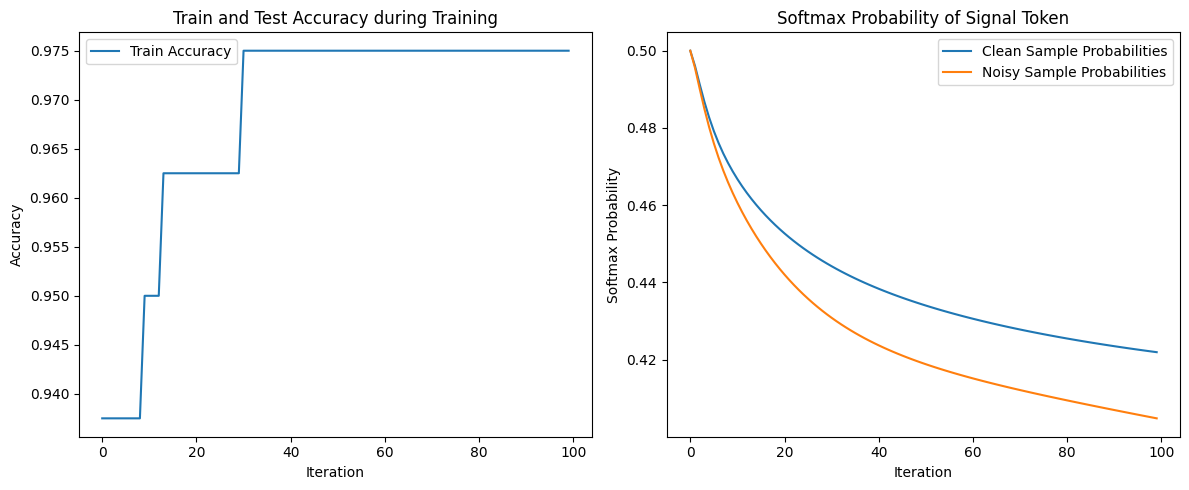

Trained v: [0.00655365 0.00203842 0.00166541 ... 0.00920995 0.00598183 0.0077866 ]
Trained p: [-0.04737323 -0.04737323 -0.04737323 ... -0.04737323 -0.04737323
 -0.04737323]


In [40]:
# Example Usage
v, p = train_model(X, y, d, 100, beta, clean_indices, noisy_indices)
print("Trained v:", v)
print("Trained p:", p)